In [141]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
import scipy
import shap
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from eclyon.transforms import (
    add_date_columns, change_columns_from_str_to_categorical, process_df, numericalize, split_vals, is_numeric_dtype
)
from eclyon.explain import rf_feat_importance, tree_feature_importance


In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This data is collected directly for the FIFA games from FIFA 15 to FIFA 24, so from 2014 to 2023 (FIFA games are released at the start of the year based on players last years stats)

This dataset was found on kaggle and has some non available data due to players not having played every year, changing clubs, not having certain stats depending on their position (goalkeepers don't have shooting ratings).

https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset/data

The goal of this project is to create a model that can predict as precisly as possible a players 2024 market value based on his last years performance.

Knowing this, I would use my predictions to underline which players are undervalued and which will have an increasing or interesting potential.

Here is a little talk about EAFC24 and how they are trying to mirror reality throught stats, and how they are evolving towards it.

https://www.fifa-infinity.com/ea-sports-fc/how-real-life-stats-shape-ea-sports-fcs-player-ratings/ 

### Exploring dataset

In [143]:
path_to_repo = Path('..').resolve()
path_to_data = path_to_repo / 'data'

In [144]:
df_raw = pd.read_csv(path_to_data / 'male_players.csv', low_memory = False)

In [145]:
df_raw.shape

(180021, 109)

In [146]:
df_raw.fifa_version

0         24.0
1         24.0
2         24.0
3         24.0
4         24.0
          ... 
180016    15.0
180017    15.0
180018    15.0
180019    15.0
180020    15.0
Name: fifa_version, Length: 180021, dtype: float64

In [147]:
df_raw.head(10)

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
5,188545,/player/188545/robert-lewandowski/240002,24.0,2.0,2023-09-22,R. Lewandowski,Robert Lewandowski,ST,90,90,...,66+3,66+3,66+3,65+3,61+3,61+3,61+3,61+3,61+3,19+3
6,192119,/player/192119/thibaut-courtois/240002,24.0,2.0,2023-09-22,T. Courtois,Thibaut Nicolas Marc Courtois,GK,90,90,...,31+3,31+3,31+3,29+3,29+3,29+3,29+3,29+3,29+3,88+2
7,202126,/player/202126/harry-kane/240002,24.0,2.0,2023-09-22,H. Kane,Harry Kane,ST,90,90,...,69+3,69+3,69+3,67+3,64+3,63+3,63+3,63+3,64+3,20+3
8,238794,/player/238794/vinicius-jose-de-oliveira-junio...,24.0,2.0,2023-09-22,Vini Jr.,Vinícius José Paixão de Oliveira Júnior,LW,89,94,...,58+3,58+3,58+3,62+3,57+3,45+3,45+3,45+3,57+3,16+3
9,212831,/player/212831/alisson-ramses-becker/240002,24.0,2.0,2023-09-22,Alisson,Alisson Ramsés Becker,GK,89,90,...,39+3,39+3,39+3,34+3,33+3,33+3,33+3,33+3,33+3,87+3


In [148]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
display_all(df_raw)

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,181500000.0,230000.0,24,1998-12-20,182,75,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,LW,7.0,NaN,2018-07-01,2024.0,18,France,1335.0,LW,10.0,Right,4,5,5,High/Low,Unique,Yes,349400000.0,"#Speedster, #Dribbler, #Acrobat, #Clinical fin...","Quick Step +, Rapid, Flair, Trivela",97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,86,84,93,80,69,71,92,97,97,93,93,82,90,88,88,77,83,64,38,93,83,84,88.0,26,34,32,13,5,7,11,6,NaN,90+3,90+3,90+3,91,91,91,91,91,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,68+3,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,185000000.0,340000.0,22,2000-07-21,195,94,10.0,Manchester City,13.0,Premier League,1.0,ST,9.0,NaN,2022-07-01,2027.0,36,Norway,1352.0,ST,9.0,Left,3,3,5,High/Medium,Unique,Yes,356100000.0,"#Aerial threat, #Distance shooter, #Strength, ...","Acrobatic +, Power Header, Quick Step",89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN,90+3,90+3,90+3,82,86,86,86,82,82+3,82+3,82+3,79+3,74+3,74+3,74+3,79+3,62+3,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,103000000.0,350000.0,32,1991-06-28,181,75,10.0,Manchester City,13.0,Premier League,1.0,SUB,17.0,NaN,2015-08-30,2025.0,7,Belgium,1325.0,CAM,7.0,Right,5,4,5,High/Medium,Unique,Yes,190600000.0,"#Dribbler, #Playmaker, #Distance shooter, #Cro...","Pinged Pass +, Dead Ball, Incisive Pass, Long ...",72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN,83+3,83+3,83+3,87,88,88,88,87,89+2,89+2,89+2,88+3,90+1,90+1,90+1,88+3,79+3,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,41000000.0,23000.0,36,1987-06-24,169,67,112893.0,Inter Miami,39.0,Major League Soccer,1.0,RF,10.0,NaN,2023-07-16,2025.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Low/Low,Unique,Yes,61500000.0,"#Dribbler, #Playmaker, #FK Specialist, #Acroba...","Technical +, Finesse Shot, Dead Ball, Pinged P...",80.0,87.0,90.0,94.0,33.0,64.0,83,89,60,91,86,96,93,93,90,93,87,74,91,88,95,83,71,70,68,90,44,40,91,92,75,96.0,20,35,24,6,11,15,14,8,NaN,85+3,85+3,85+3,90,89,89,89,90,91-1,91-1,91-1,89+1,85+3,85+3,85+3,89+1,64+3,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,

In [149]:
df_updates = df_raw.groupby(['short_name','fifa_version'])['value_eur'].mean()
df_updates_table = df_updates.unstack(fill_value = np.nan)
display_all(df_updates_table)
#This way of seeing the dataset permits looking at player evolution, which we can't really comprehend otherwise

fifa_version,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
short_name,,,,,,,,,,
A Lan,4000000.0,NaN,NaN,NaN,8000000.0,10500000.0,10500000.0,9000000.0,NaN,NaN
A. Abang,NaN,250000.0,425000.0,NaN,425000.0,NaN,NaN,NaN,NaN,NaN
A. Abass,40000.0,70000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A. Abaz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120000.0,100000.0,170000.0
A. Abbas,350000.0,187500.0,337500.0,247500.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Ș. Radu,4900000.0,8000000.0,7500000.0,9000000.0,10000000.0,9500000.0,6500000.0,3400000.0,1500000.0,NaN
Ș. Rusu,NaN,NaN,NaN,NaN,NaN,210000.0,275000.0,NaN,NaN,NaN
Ș. Tomache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130000.0,NaN


In [150]:
df_raw.value_eur

0         181500000.0
1         185000000.0
2         103000000.0
3          41000000.0
4          51000000.0
             ...     
180016        20000.0
180017        30000.0
180018        15000.0
180019        15000.0
180020            NaN
Name: value_eur, Length: 180021, dtype: float64

In [151]:
player_value = df_raw.value_eur.tolist()

#### Which variables do we need to keep?

(small walkthrough of how my knowledge of the field helps understand the dataset)

Primary Foot and Weak foot

Left-footed players are less common, making up approximately 20% of professional players compared to only 10% of the general population, which increases their perceived value.
 This scarcity is particularly significant in specific positions such as left-back (LB), left-wing (LW), and increasingly left-centre-back (LCB), where left-footed players are often preferred.
 Teams typically seek left-footed players for these roles because they can offer a unique angle of attack and unpredictability against right-footed defenders who are more accustomed to facing right-footed opponents.

Players with higher weak foot ratings (4-5) are even better in that domain as they provide more flexibility, what managers seek for.

Jersey Numbers

Jersey Numbers impact the spectator's expectation from a player. In football, a player can choose his number from 1 to 100. But, certain positions have been duely associated with a number: the number 10 is for the playmaker, number 9 for the striker, 1 for the goalkeeper,... Having that number on your jersey shows that this player is the 1st choice on paper for that position. Having a good number (either the first choice numbers or, for players who can play different positions) in both national and club shows how important you are as a player. This is very correlated to the qualities of a player, but also reflects an element that isn't talked about by the other variables: brand exposure.

Fifa update and version

Fifa version acts for a time statistic, whereas fifa updates is usually more used to add special cards or events to give change to the game. So updates do not affect what we search, which we will verify later, so maybe delete this row.

Positions

Obviously a position affects a players worth differently: defenders are often undergraded so therefore undervalued. Why? Attackers get more media coverage, scoring a goal provoques change whereas stopping one doesn't. 

Ratings

Ratings are the core of modelisation of a player's abilities and real life modelisation.

### Pre-processing

In [152]:
#transforming the "club joined date" column into 3 "day", "month", "year" to better underline the signing year's effect
df_transformed = add_date_columns(df_raw, fields = ['club_joined_date'])

C:\Users\hauti\Desktop\ECLyon-ML-Course-2024-T4-main\src\eclyon\transforms.py:24: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[field] = fld = pd.to_datetime(fld, infer_datetime_format = True)


In [153]:
df_isnull_describe = df_raw.isnull().describe()
df_raw.isnull().describe()

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
count,180021,180021,180021,180021,180021,180021,180021,180021,180021,180021,...,180021,180021,180021,180021,180021,180021,180021,180021,180021,180021
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,180021,180021,180021,180021,180021,180021,180021,180021,180021,180021,...,180021,180021,180021,180021,180021,180021,180021,180021,180021,180021


In [154]:
df_isnull_describe['physic']['unique']

2

In [155]:
df_isnull_describe['physic']

count     180021
unique         2
top        False
freq      159997
Name: physic, dtype: object

In [156]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [157]:
def print_score(m, X_train, Y_train, X_valid, Y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), Y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), Y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, Y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, Y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return


In [158]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

age                               0.000000
attacking_crossing                0.000000
attacking_finishing               0.000000
attacking_heading_accuracy        0.000000
attacking_short_passing           0.000000
attacking_volleys                 0.000000
body_type                         0.000000
cam                               0.000000
cb                                0.000000
cdm                               0.000000
cf                                0.000000
club_contract_valid_until_year    0.010360
club_jersey_number                0.010360
club_joined_date                  0.069925
club_loaned_from                  0.940435
club_name                         0.010360
club_position                     0.010360
club_team_id                      0.010360
cm                                0.000000
defending                         0.111231
defending_marking_awareness       0.000000
defending_sliding_tackle          0.000000
defending_standing_tackle         0.000000
dob        

In [159]:
df_raw.club_contract_valid_until_year

0         2024.0
1         2027.0
2         2025.0
3         2025.0
4         2026.0
           ...  
180016    2015.0
180017    2015.0
180018    2015.0
180019    2021.0
180020    2015.0
Name: club_contract_valid_until_year, Length: 180021, dtype: float64

In [160]:
display_all(df_transformed[df_transformed['club_loaned_from'].isnull() == True])

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,club_joined_Year,club_joined_Month,club_joined_Day,club_joined_Dayofweek,club_joined_Dayofyear,club_joined_Is_month_start,club_joined_Is_month_end,club_joined_Is_quarter_start,club_joined_Is_quarter_end,club_joined_Is_year_start,club_joined_Is_year_end,club_joined_Elapsed
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,181500000.0,230000.0,24,1998-12-20,182,75,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,LW,7.0,NaN,2024.0,18,France,1335.0,LW,10.0,Right,4,5,5,High/Low,Unique,Yes,349400000.0,"#Speedster, #Dribbler, #Acrobat, #Clinical fin...","Quick Step +, Rapid, Flair, Trivela",97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,86,84,93,80,69,71,92,97,97,93,93,82,90,88,88,77,83,64,38,93,83,84,88.0,26,34,32,13,5,7,11,6,NaN,90+3,90+3,90+3,91,91,91,91,91,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,68+3,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3,2018.0,7.0,1.0,6.0,182.0,True,False,True,False,False,False,1530403200
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,185000000.0,340000.0,22,2000-07-21,195,94,10.0,Manchester City,13.0,Premier League,1.0,ST,9.0,NaN,2027.0,36,Norway,1352.0,ST,9.0,Left,3,3,5,High/Medium,Unique,Yes,356100000.0,"#Aerial threat, #Distance shooter, #Strength, ...","Acrobatic +, Power Header, Quick Step",89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN,90+3,90+3,90+3,82,86,86,86,82,82+3,82+3,82+3,79+3,74+3,74+3,74+3,79+3,62+3,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3,2022.0,7.0,1.0,4.0,182.0,True,False,True,False,False,False,1656633600
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,103000000.0,350000.0,32,1991-06-28,181,75,10.0,Manchester City,13.0,Premier League,1.0,SUB,17.0,NaN,2025.0,7,Belgium,1325.0,CAM,7.0,Right,5,4,5,High/Medium,Unique,Yes,190600000.0,"#Dribbler, #Playmaker, #Distance shooter, #Cro...","Pinged Pass +, Dead Ball, Incisive Pass, Long ...",72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN,83+3,83+3,83+3,87,88,88,88,87,89+2,89+2,89+2,88+3,90+1,90+1,90+1,88+3,79+3,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3,2015.0,8.0,30.0,6.0,242.0,False,False,False,False,False,False,1440892800
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,41000000.0,23000.0,36,1987-06-24,169,67,112893.0,Inter Miami,39.0,Major League Soccer,1.0,RF,10.0,NaN,2025.0,52,A

In [161]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180021 entries, 0 to 180020
Columns: 109 entries, player_id to gk
dtypes: float64(20), int64(43), object(46)
memory usage: 149.7+ MB


In [162]:
#Looking at the "trait" column
traits = df_raw['player_traits'].dropna()
unique_traits = []
for i in traits:
    col_has = i.split(',')
    for j in range(len(col_has)):
        col_has[j] = col_has[j].rstrip(' (AI)').rstrip(' +')
    unique_traits.extend(col_has)

sut = set(unique_traits)
print('Number of uniques', len(sut))
display_all(sut)

Number of uniques 126


{' 1-on-1 Rush',
 ' Acrobatic',
 ' Aerial',
 ' Anticipate',
 ' Avoids Using Weaker Foot',
 ' Backs Into Player',
 ' Beat Offside Trap',
 ' Block',
 ' Bruiser',
 ' Cautious With Crosses',
 ' Chip Shot',
 ' Comes For Crosses',
 ' Dead Ball',
 ' Diver',
 ' Dives Into Tackles',
 ' Early Crosser',
 ' Finesse Shot',
 ' First Touch',
 ' Flair',
 ' Footwork',
 ' GK Long Throw',
 ' GK Up for Corners',
 ' Giant Throw-in',
 ' Incisive Pass',
 ' Injury Free',
 ' Injury Prone',
 ' Intercept',
 ' Jockey',
 ' Leadership',
 ' Long Ball Pass',
 ' Long Passer',
 ' Long Shot Taker',
 ' Long Throw',
 ' One Club Player',
 ' Outside Foot Shot',
 ' Pinged Pass',
 ' Playmaker',
 ' Power Free-Kick',
 ' Power Header',
 ' Power Shot',
 ' Press Proven',
 ' Puncher',
 ' Quick Step',
 ' Rapid',
 ' Relentless',
 ' Rushes Out Of Goal',
 ' Saves with Feet',
 ' Selfish',
 ' Set Play Specialist',
 ' Slide Tackle',
 ' Solid Player',
 ' Speed Dribbler',
 ' Swerve Pass',
 ' Takes Finesse Free Kicks',
 ' Target Forward',
 '

In [163]:
numeric_cols = ['overall','wage_eur','value_eur','release_clause_eur','potential','age','height_cm','weight_kg','league_level','pace','shooting','passing','dribbling','defending','physic','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots','mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed']
int_score_pos = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk']
for col in int_score_pos:
    df_transformed[col] = df_transformed[col].str.slice(0, 2)
# L'opération de dessus a pour but de transformer des valeurs comme 90+3 en 90: Ici, +3 indique que le joueur est boosté en équipe international sur ce poste précis.
# Donc soit je créée de nouvelles colonnes pour guarder ces informations, soit je perds cette information.
# J'ai décidé qu'elle ne valait pas l'intérêt.
df_transformed[numeric_cols] = df_transformed[numeric_cols].fillna(df_transformed[numeric_cols].median())
# Ici je modifie juste pour remplacer les nan en valeur médiane
zero_cols = ['nation_jersey_number', 'nation_position', 'nation_team_id', 'player_tags', 'player_traits']
# Et puis je remplace les valeurs manquantes par un 0: les "zero columns" font référence à des attributs qu'un joueur ou non, donc les 0 vont indiquer que le joueur n'a pas cet/ces attribu/s.
df_transformed[zero_cols] = df_transformed[zero_cols].fillna(0)
display_all(df_transformed.isnull().sum().sort_index()/len(df_transformed))

age                               0.000000
attacking_crossing                0.000000
attacking_finishing               0.000000
attacking_heading_accuracy        0.000000
attacking_short_passing           0.000000
attacking_volleys                 0.000000
body_type                         0.000000
cam                               0.000000
cb                                0.000000
cdm                               0.000000
cf                                0.000000
club_contract_valid_until_year    0.010360
club_jersey_number                0.010360
club_joined_Day                   0.069925
club_joined_Dayofweek             0.069925
club_joined_Dayofyear             0.069925
club_joined_Elapsed               0.000000
club_joined_Is_month_end          0.000000
club_joined_Is_month_start        0.000000
club_joined_Is_quarter_end        0.000000
club_joined_Is_quarter_start      0.000000
club_joined_Is_year_end           0.000000
club_joined_Is_year_start         0.000000
club_joined

In [164]:
#df_transformed = df_transformed.drop(columns = ['preferred_foot_Right'])
#df_pf = pd.get_dummies(df_raw[['preferred_foot']]).astype(int)
#df_pf = df_pf.drop(columns = ['preferred_foot_Left'])
#df_pf
#A code to change the "preferred foot" column into a numeric boolean column

In [165]:
#df_transformed = pd.concat([df_transformed, df_pf], axis=1)
#df_transformed

In [166]:
df_processed = df_transformed.copy()
for i in df_processed.columns:
    numericalize(df_processed, col= df_processed[i], name=i, max_n_cat=None)
df_processed.shape

(180021, 120)

In [167]:
boolean_col = ['club_joined_Is_quarter_start', 'club_joined_Is_year_end', 'club_joined_Is_year_start', 'club_joined_Is_quarter_end', 'club_joined_Is_month_end', 'club_joined_Is_month_start']
df_processed[boolean_col] = df_processed[boolean_col].astype(int)

In [168]:
#for i in df_processed.columns:
#    if not is_numeric_dtype(df_processed[i]):
#        df_processed = df_processed.drop(columns=i)
to_drop = df_processed.select_dtypes(include=["object", "category"]).columns
df_processed = df_processed.drop(columns=to_drop)
df_processed.columns.shape[0]

75

C:\Users\hauti\AppData\Local\Temp\ipykernel_1896\3563123829.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + col_small)
C:\Users\hauti\AppData\Local\Temp\ipykernel_1896\3563123829.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + col_small)


[Text(0, -1.0, ''),
 Text(0, 0.0, 'attacking_finishing'),
 Text(0, 1.0, 'wage_eur'),
 Text(0, 2.0, 'nation_jersey_number'),
 Text(0, 3.0, 'pace'),
 Text(0, 4.0, 'skill_moves'),
 Text(0, 5.0, 'overall'),
 Text(0, 6.0, 'potential'),
 Text(0, 7.0, 'physic'),
 Text(0, 8.0, '')]

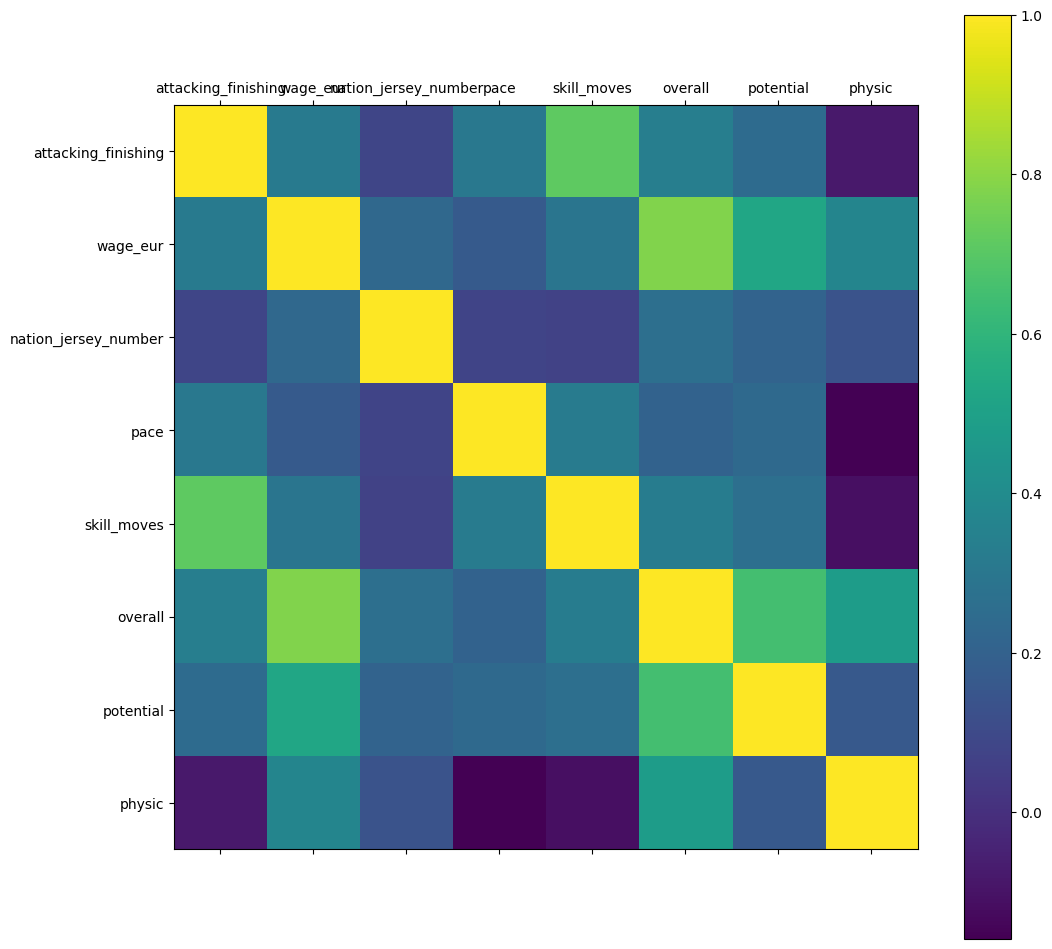

In [169]:
col_small = [
    'attacking_finishing',
    'wage_eur',
    'nation_jersey_number',
    'pace',
    'skill_moves',
    'overall',
    'potential',
    'physic',
]
corr_small = np.round(scipy.stats.spearmanr(df_transformed[col_small]).correlation, 4)
corr_small.size

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_small)

fig.colorbar(cax)

ax.set_xticklabels([''] + col_small)
ax.set_yticklabels([''] + col_small)

### PCA 

In [170]:
X = pd.DataFrame()
for i in numeric_cols:
    X[i] = df_transformed[i].copy()
X

,overall,wage_eur,value_eur,release_clause_eur,potential,age,height_cm,weight_kg,league_level,pace,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,91,230000.0,181500000.0,349400000.0,94,24,182,75,1.0,97.0,...,88.0,26,34,32,13,5,7,11,6,40.0
1,91,340000.0,185000000.0,356100000.0,94,22,195,94,1.0,89.0,...,87.0,38,47,29,7,14,13,11,7,40.0
2,91,350000.0,103000000.0,190600000.0,91,32,181,75,1.0,72.0,...,88.0,66,70,53,15,13,5,10,13,40.0
3,90,23000.0,41000000.0,61500000.0,90,36,169,67,1.0,80.0,...,96.0,20,35,24,6,11,15,14,8,40.0
4,90,95000.0,51000000.0,81600000.0,90,35,185,81,1.0,79.0,...,90.0,43,24,18,13,11,5,5,7,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,41,2000.0,20000.0,1400000.0,61,17,187,81,4.0,66.0,...,59.0,38,40,35,12,6,15,8,6,40.0
180017,41,2000.0,30000.0,1400000.0,50,17,178,57,4.0,64.0,...,59.0,25,25,25,13,11,12,15,11,40.0
180018,40,2000.0,15000.0,1400000.0,50,18,190,76,1.0,58.0,...,59.0,54,52,51,8,14,7,10,9,40.0
180019,40,2000.0,15000.0,1400000.0,49,22,180,70,3.0,72.0,...,59.0,36,34,35,15,13,6,11,9,40.0


In [171]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
Z = pca.fit_transform(X_scaled)
pca_results = []

In [172]:
for i in range(1, len(numeric_cols)+1):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_scaled)          
    explained_var = pca.explained_variance_ratio_ * 100
    pca_results.append((i, explained_var, explained_var.sum()))
    print(f"n_components={i}: explained var (%) per PC = {sum(explained_var)}, total = {explained_var.sum():.2f}%")

n_components=1: explained var (%) per PC = 40.22162068898359, total = 40.22%
n_components=2: explained var (%) per PC = 54.939928590212915, total = 54.94%
n_components=3: explained var (%) per PC = 66.86809668608319, total = 66.87%
n_components=4: explained var (%) per PC = 72.75248695390795, total = 72.75%
n_components=5: explained var (%) per PC = 76.9859168062042, total = 76.99%
n_components=6: explained var (%) per PC = 80.42869499659768, total = 80.43%
n_components=7: explained var (%) per PC = 82.69435198327378, total = 82.69%
n_components=8: explained var (%) per PC = 84.69963732477571, total = 84.70%
n_components=9: explained var (%) per PC = 86.55403115053284, total = 86.55%
n_components=10: explained var (%) per PC = 88.02198852435832, total = 88.02%
n_components=11: explained var (%) per PC = 89.11363367415552, total = 89.11%
n_components=12: explained var (%) per PC = 90.02156150381502, total = 90.02%
n_components=13: explained var (%) per PC = 90.89896584686737, total = 90

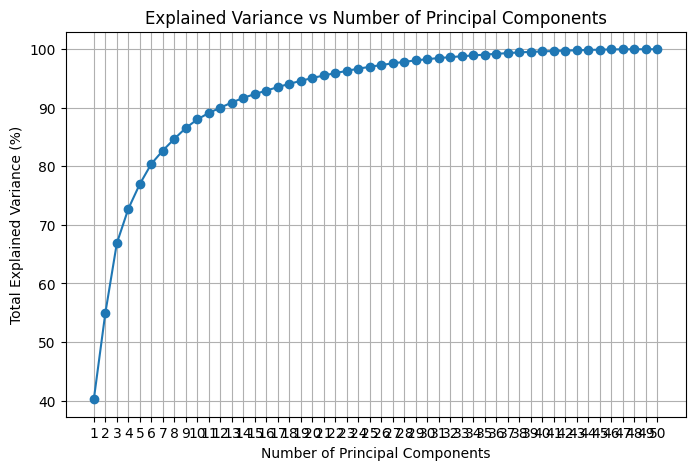

In [173]:
plt.figure(figsize=(8, 5))
n_components_list = [res[0] for res in pca_results]
total_explained_var = [res[2] for res in pca_results]
plt.plot(n_components_list, total_explained_var, marker='o')
plt.xticks(n_components_list)
plt.xlabel("Number of Principal Components")
plt.ylabel("Total Explained Variance (%)")
plt.title("Explained Variance vs Number of Principal Components")
plt.grid()
plt.show()

PCA is here used to demonstrate that a certain number of principal components can provide enough information about the dataset whilst maintaining complexity down.

### First Models

In [174]:
fifa_v_23 = df_transformed[df_transformed['fifa_version'] == 23.0].copy()
fifa_v_23.shape

(18533, 120)

In [175]:
fifa_v_24 = df_transformed[df_transformed['fifa_version'] == 24.0].copy()
fifa_v_24.shape
#These are attempts to make a model that could train on one FIFAs data to predict te values of another without leakage

(18350, 120)

In [176]:
n_valid_23 = 6000
n_trn_23 = len(fifa_v_23) - n_valid_23
n_valid_24 = 6000
n_trn_24 = len(fifa_v_24) - n_valid_24

In [177]:
without_y, y , nas = process_df(fifa_v_23, 'value_eur', skip_flds= ['release_clause_eur'])
y = y.astype(int)
X_train, X_valid = split_vals(without_y, n_trn_23)
y_train, y_valid = split_vals(y, n_trn_23)

In [178]:
without_y_24, y_24 , nas_24 = process_df(fifa_v_24, 'value_eur', skip_flds= ['release_clause_eur'])
y_24 = y_24.astype(int)
X_train_24, X_valid_24 = split_vals(without_y_24, n_trn_24)
y_train_24, y_valid_24 = split_vals(y_24, n_trn_24)

In [179]:
y = pd.DataFrame(y)
y_24 = pd.DataFrame(y_24)

In [180]:
if isinstance(without_y, dict):
    without_y = pd.DataFrame(without_y, index =[range(18533)])
if isinstance(without_y_24, dict):
    without_y_24 = pd.DataFrame(without_y, index =[range(18550)])

In [181]:
model = RandomForestRegressor(n_estimators = 11, 
                              n_jobs = -1, 
                              random_state = 42,
                              bootstrap= True,
                              oob_score= True,
                              ccp_alpha=0.001,
                              )
model.fit(without_y_24, y_24)

c:\Users\hauti\anaconda3\envs\ecl-course-2025\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hauti\anaconda3\envs\ecl-course-2025\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(ccp_alpha=0.001, n_estimators=11, n_jobs=-1,
                      oob_score=True, random_state=42)

In [182]:
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 1418730.6669
RMSE on valid set: 18231.0533
R^2 on train set: 0.9751
R^2 on valid set: 0.9934
R^2 on oob set: 0.9556


In [183]:
print_score(model, X_train_24, y_train_24, X_valid_24, y_valid_24)
# both models are almost perfect but the oob score hints a leakage possibility, the model interprets the two datasets as if they were identical

RMSE on train set: 651168.4524
RMSE on valid set: 8467.9126
R^2 on train set: 0.9947
R^2 on valid set: 0.9986
R^2 on oob set: 0.9556


In [184]:
X_train_24

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,club_joined_Elapsed,club_team_id_na,league_id_na,club_jersey_number_na,club_contract_valid_until_year_na,club_joined_Year_na,club_joined_Month_na,club_joined_Day_na,club_joined_Dayofweek_na,club_joined_Dayofyear_na
0,231747,5895,24.0,2.0,1,8919,9705,691,91,94,...,1530403200,False,False,False,False,False,False,False,False,False
1,239085,7479,24.0,2.0,1,4431,4918,667,91,94,...,1656633600,False,False,False,False,False,False,False,False,False
2,192985,862,24.0,2.0,1,8717,9406,178,91,91,...,1440892800,False,False,False,False,False,False,False,False,False
3,158023,64,24.0,2.0,1,9761,10116,141,90,90,...,1689465600,False,False,False,False,False,False,False,False,False
4,165153,95,24.0,2.0,1,8664,9251,171,90,90,...,1688169600,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345,250812,10047,24.0,2.0,1,14251,14832,366,63,68,...,1507939200,False,False,False,False,False,False,False,False,False
12346,251317,10201,24.0,2.0,1,849,844,260,63,68,...,1688169600,False,False,False,False,False,False,False,False,False
12347,252659,10582,24.0,2.0,1,9208,4319,259,63,68,...,1546560000,False,False,False,False,False,False,False,False,False
12348,252710,10592,24.0,2.0,1,14270,14446,700,63,68,...,1688688000,False,False,False,False,False,False,False,False,False


In [185]:
feat_importance = rf_feat_importance(model, X_train)
feat_importance[:20]

,cols,imp
8,overall,0.683133
9,potential,0.253425
12,dob,0.016997
11,age,0.006067
81,rs,0.005493
90,lm,0.003009
55,movement_sprint_speed,0.001995
83,lf,0.001760
0,player_id,0.001311
20,club_position,0.001285


In [186]:
display_all(df_processed)

,player_id,fifa_version,fifa_update,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_jersey_number,club_contract_valid_until_year,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,club_joined_Year,club_joined_Month,club_joined_Day,club_joined_Dayofweek,club_joined_Dayofyear,club_joined_Is_month_start,club_joined_Is_month_end,club_joined_Is_quarter_start,club_joined_Is_quarter_end,club_joined_Is_year_start,club_joined_Is_year_end,club_joined_Elapsed
0,231747,24.0,2.0,91,94,181500000.0,230000.0,24,182,75,73.0,16.0,1.0,7.0,2024.0,18,1335.0,10.0,4,5,5,349400000.0,97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,86,84,93,80,69,71,92,97,97,93,93,82,90,88,88,77,83,64,38,93,83,84,88.0,26,34,32,13,5,7,11,6,40.0,2018.0,7.0,1.0,6.0,182.0,1,0,1,0,0,0,1530403200
1,239085,24.0,2.0,91,94,185000000.0,340000.0,22,195,94,10.0,13.0,1.0,9.0,2027.0,36,1352.0,9.0,3,3,5,356100000.0,89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,40.0,2022.0,7.0,1.0,4.0,182.0,1,0,1,0,0,0,1656633600
2,192985,24.0,2.0,91,91,103000000.0,350000.0,32,181,75,10.0,13.0,1.0,17.0,2025.0,7,1325.0,7.0,5,4,5,190600000.0,72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,40.0,2015.0,8.0,30.0,6.0,242.0,0,0,0,0,0,0,1440892800
3,158023,24.0,2.0,90,90,41000000.0,23000.0,36,169,67,112893.0,39.0,1.0,10.0,2025.0,52,1369.0,10.0,4,4,5,61500000.0,80.0,87.0,90.0,94.0,33.0,64.0,83,89,60,91,86,96,93,93,90,93,87,74,91,88,95,83,71,70,68,90,44,40,91,92,75,96.0,20,35,24,6,11,15,14,8,40.0,2023.0,7.0,16.0,6.0,197.0,0,0,0,0,0,0,1689465600
4,165153,24.0,2.0,90,90,51000000.0,95000.0,35,185,81,607.0,350.0,1.0,9.0,2026.0,18,0.0,0.0,4,4,5,81600000.0,79.0,88.0,83.0,87.0,39.0,78.0,75,91,90,89,88,87,82,73,76,91,78,79,77,92,72,87,85,82,82,81,63,39,92,90,85,90.0,43,24,18,13,11,5,5,7,40.0,2023.0,7.0,1.0,5.0,182.0,1,0,1,0,0,0,1688169600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,15.0,2.0,41,61,20000.0,2000.0,17,187,81,112254.0,61.0,4.0,35.0,2015.0,50,0.0,0.0,2,2,1,1400000.0,66.0,25.0,29.0,30.0,39.0,53.0,25,25,41,36,25,25,21,25,33,26,65,66,52,36,55,22,62,56,52,25,50,41,25,22,31,59.0,38,40,35,12,6,15,8,6,40.0,2013.0,10.0,22.0,1.0,295.0,0,0,0,0,0,0,1382400000
180017,225509,15.0,2.0,41,50,30000.0,2000.0,17,178,57,112254.0,61.0,4.0,39.0,2015.0,50,0.0,0.0,3,3,1,1400000.0,64.0,41.0,27.0,35.0,27.0,41.0,22,47,43,25,27,29,20,22,24,30,60,68,66,39,68,36,51,47,42,36,30,25,41,39,47,59.0,25,25,25,13,11,12,15,11,40.0,2014.0,8.0,14.0,3.0,226.0,0,0,0,0,0,0,1407974400
180018,217591,15.0,2.0,40,50,15000.0,2000.0,18,190,76,1873.0,66.0,1.0,43.0,2015.0,37,0.0,0.0,3,2,1,1400000.0,58.0,27.0,35.0,31.0,52.0,68.0,49,24,57,40,25,27,24,21,34,32,57,58,36,50,44,31,61,74,75,25,44,47,38,21,31,59.0,54,52,51,8,14,7,10,9,40.0,2012.0,7.0,1.0,6.0,183.0,1,0,1,0,0,0,1341100800
180019,

In [187]:
n_total = len(df_transformed)
n_valid = 60000
n_train = n_total - n_valid
n_small = 20000
df_withouty, y2, nas= process_df(df_transformed, 'value_eur')

In [188]:
df_withouty

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,club_joined_Elapsed,club_team_id_na,league_id_na,club_jersey_number_na,club_contract_valid_until_year_na,club_joined_Year_na,club_joined_Month_na,club_joined_Day_na,club_joined_Dayofweek_na,club_joined_Dayofyear_na
0,231747,13970,24.0,2.0,10,24117,27876,1968,91,94,...,1530403200,False,False,False,False,False,False,False,False,False
1,239085,17312,24.0,2.0,10,12048,14284,1886,91,94,...,1656633600,False,False,False,False,False,False,False,False,False
2,192985,2365,24.0,2.0,10,23547,27059,508,91,91,...,1440892800,False,False,False,False,False,False,False,False,False
3,158023,227,24.0,2.0,10,26351,28996,424,90,90,...,1689465600,False,False,False,False,False,False,False,False,False
4,165153,347,24.0,2.0,10,23398,26634,491,90,90,...,1688169600,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,112625,15.0,2.0,1,12591,13408,206,41,61,...,1382400000,False,False,False,False,False,False,False,False,False
180017,225509,124017,15.0,2.0,1,941,41,1886,41,50,...,1407974400,False,False,False,False,False,False,False,False,False
180018,217591,108750,15.0,2.0,1,36291,39856,958,40,50,...,1341100800,False,False,False,False,False,False,False,False,False
180019,222947,117237,15.0,2.0,1,42558,46209,206,40,49,...,1394496000,False,False,False,False,False,False,False,False,False


In [189]:
cols = numeric_cols + zero_cols 
cols.remove('nation_position')
cols.remove('player_tags')
cols.remove('player_traits')
corr = np.round(scipy.stats.spearmanr(df_processed[cols]).correlation, 6)
corr.size

2704

In [190]:
corr_linkage = hierarchy.linkage(corr, method = 'average')

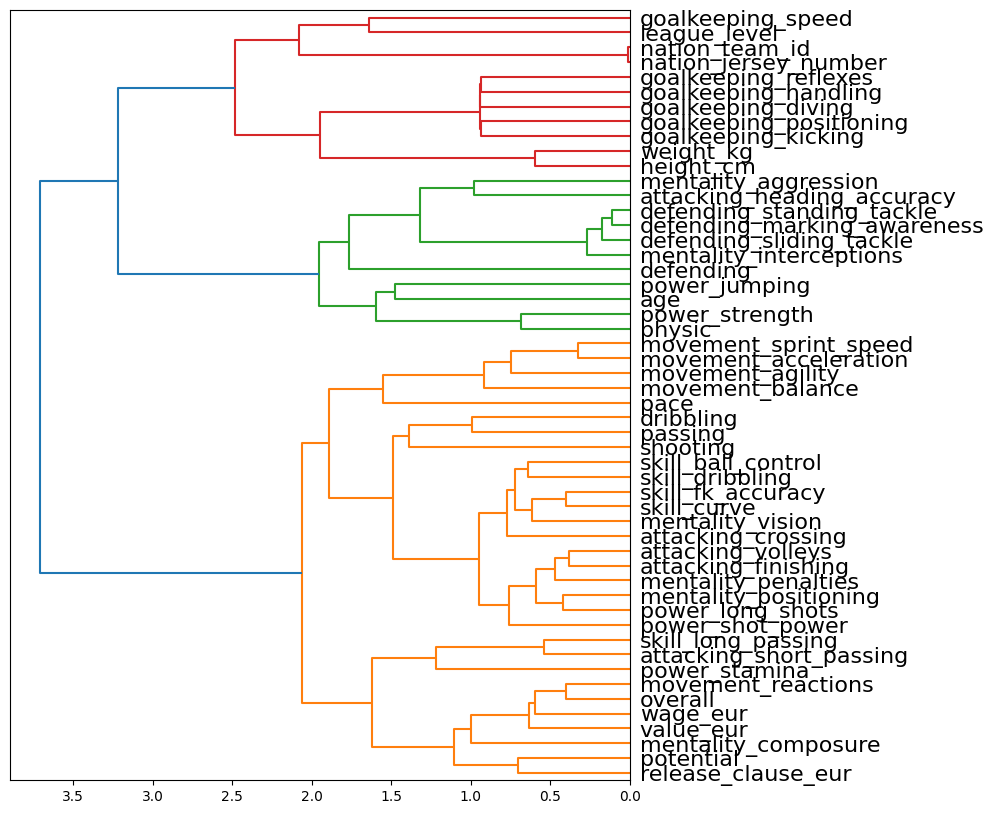

In [191]:
fig = plt.figure(figsize = (8,10))
dendrogram = hierarchy.dendrogram(
    corr_linkage, 
    labels = cols, 
    orientation = 'left', 
    leaf_font_size = 16,
)
plt.show()
# The dendogram shows us multiple things: We can see three main groups, one is goalkeeping, other is defending, and the biggest is pace, shooting and passing.
# There is an unexpected relationship between movement_reactions and overall (which directly impacts wage and then value).
# What we can conclude, is that a player is going to be more valuable if he is an attacking player and with a better adaptieness.

In [192]:
X_train, X_valid = split_vals(df_withouty, 120000)
Y_train, Y_valid = split_vals(y2, 120000)
X_small, _ = split_vals(X_train, n_small)
Y_small, _ = split_vals(Y_train, n_small)

In [193]:
model = RandomForestRegressor(n_estimators = 11, 
                              n_jobs = -1, 
                              random_state = 42,
                              bootstrap= True,
                              oob_score= True,
                              ccp_alpha=0.001,
                              )
model.fit(df_withouty, y2)

c:\Users\hauti\anaconda3\envs\ecl-course-2025\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(ccp_alpha=0.001, n_estimators=11, n_jobs=-1,
                      oob_score=True, random_state=42)

In [194]:
print_score(model, X_train, Y_train, X_valid, Y_valid)

RMSE on train set: 390328.0851
RMSE on valid set: 203755.3777
R^2 on train set: 0.9969
R^2 on valid set: 0.9968
R^2 on oob set: 0.9662


In [195]:
new_player_data = {
    'player_id': 247637,
    'player_url': 0,
    'fifa_version': 20.0,
    'fifa_update': 2.0,
    'update_as_of': 2019-9-19,
    'short_name': 0,
    'long_name':0,
    'player_positions': 3,
    'overall': 60,
    'potential': 72,
    'wage_eur': 1000.0,
    'age': 20,
    'dob':1999-3-15,
    'height_cm': 180,
    'weight_kg': 59,
    'club_team_id': 112996,
    'club_name': 0,
    'league_id': 39.0,
    'league_name': 0,
    'league_level': 1,
    'club_position': 1,
    'club_jersey_number': 11,
    'club_loaned_from': 0,
    'club_contract_valid_until_year': 2022,
    'nationality_id': 82,
    'nationality_name': 86,
    'nation_team_id': 0,
    'nation_position': 0,
    'nation_jersey_number': 0,
    'preferred_foot': 0,
    'weak_foot': 2,
    'skill_moves': 2,
    'international_reputation': 1,
    'work_rate': 1,
    'body_type': 0,
    'real_face': 1,
    'release_clause_eur': 638000,
    'player_tags': 0,
    'player_traits': 0,
    'pace': 68,
    'shooting': 48,
    'passing': 57,
    'dribbling': 61,
    'defending': 50,
    'physic': 55,
    'attacking_crossing': 44,
    'attacking_finishing': 48,
    'attacking_heading_accuracy': 48,
    'attacking_short_passing': 64,
    'attacking_volleys': 37,
    'skill_dribbling': 62,
    'skill_curve': 43,
    'skill_fk_accuracy': 38,
    'skill_long_passing': 62,
    'skill_ball_control': 59,
    'movement_acceleration': 70,
    'movement_sprint_speed': 66,
    'movement_agility': 62,
    'movement_reactions': 59,
    'movement_balance': 59,
    'power_shot_power': 52,
    'power_jumping': 62,
    'power_stamina': 61,
    'power_strength': 52,
    'power_long_shots': 46,
    'mentality_aggression': 52,
    'mentality_interceptions': 49,
    'mentality_positioning': 54,
    'mentality_vision': 61,
    'mentality_penalties': 39,
    'mentality_composure': 59,
    'defending_marking_awareness': 51,
    'defending_standing_tackle': 52,
    'defending_sliding_tackle': 43,
    'goalkeeping_diving': 14,
    'goalkeeping_handling': 9,
    'goalkeeping_kicking': 14,
    'goalkeeping_positioning': 10,
    'goalkeeping_reflexes': 7,
    'goalkeeping_speed': 0 ,
    'ls': 55+2,
    'st': 55+2,
    'rs': 55+2,
    'lw': 58,
    'lf': 58,
    'cf': 58,
    'rf': 58,
    'rw': 58,
    'lam': 59+2,
    'cam': 59+2,
    'ram': 59+2,
    'lm': 59+2,
    'lcm': 59+2,
    'cm': 59+2,
    'rcm': 59+2,
    'rm': 59+2,
    'lwb': 55+2,
    'ldm': 56+2,
    'cdm': 56+2,
    'rdm': 56+2,
    'rwb': 55+2,
    'lb': 54+2,
    'lcb': 52+2,
    'cb': 52+2,
    'rcb': 52+2,
    'rb': 54+2,
    'gk': 16+2,
    'club_joined_Year': 2019,
    'club_joined_Month': 1,
    'club_joined_Day': 11,
    'club_joined_Dayofweek':5,
    'club_joined_Dayofyear': 11,
    'club_joined_Is_month_start':False,
    'club_joined_Is_month_end':True,
    'club_joined_Is_quarter_start': True,
    'club_joined_Is_quarter_end': True,
    'club_joined_Is_year_start':True,
    'club_joined_Is_year_end': True,
    'club_joined_Elapsed':1407974400,
    'club_team_id_na': False,
    'league_id_na': False,
    'club_jersey_number_na': False,
    'club_contract_valid_until_year_na': 0,
    'club_joined_Year_na': False,
    'club_joined_Month_na': False,
    'club_joined_Day_na': False,
    'club_joined_Dayofweek_na': False,
    'club_joined_Dayofyear_na': False,
}


In [196]:
new_player_data = pd.DataFrame(new_player_data, index = [range(1,109)])

In [197]:
predicted_value = model.predict(new_player_data)

In [198]:
print(f" **{predicted_value[0]:,.0f} Euros**") #Real value 375 000€

 **278,182 Euros**


In [199]:
df_new = pd.DataFrame(new_player_data, index=[0])

In [200]:
result = permutation_importance(
    model, 
    X_valid, 
    Y_valid, 
    n_repeats = 5,
    random_state = 42, 
    n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()
sorted_idx = sorted_idx[-10:]

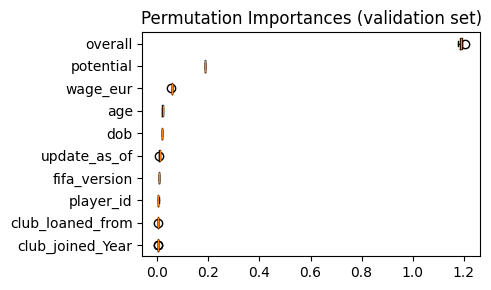

In [201]:
fig, ax = plt.subplots(figsize = (5, 3))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    tick_labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [202]:
print_score(model, X_train, Y_train, X_valid, Y_valid)

RMSE on train set: 390328.0851
RMSE on valid set: 203755.3777
R^2 on train set: 0.9969
R^2 on valid set: 0.9968
R^2 on oob set: 0.9662


In [203]:
feat_importance = rf_feat_importance(model, X_small)
feat_importance[:20]

,cols,imp
36,release_clause_eur,0.743683
8,overall,0.160669
9,potential,0.028448
10,wage_eur,0.024813
11,age,0.005486
4,update_as_of,0.005032
2,fifa_version,0.004840
12,dob,0.003047
17,league_id,0.001360
56,movement_sprint_speed,0.000892


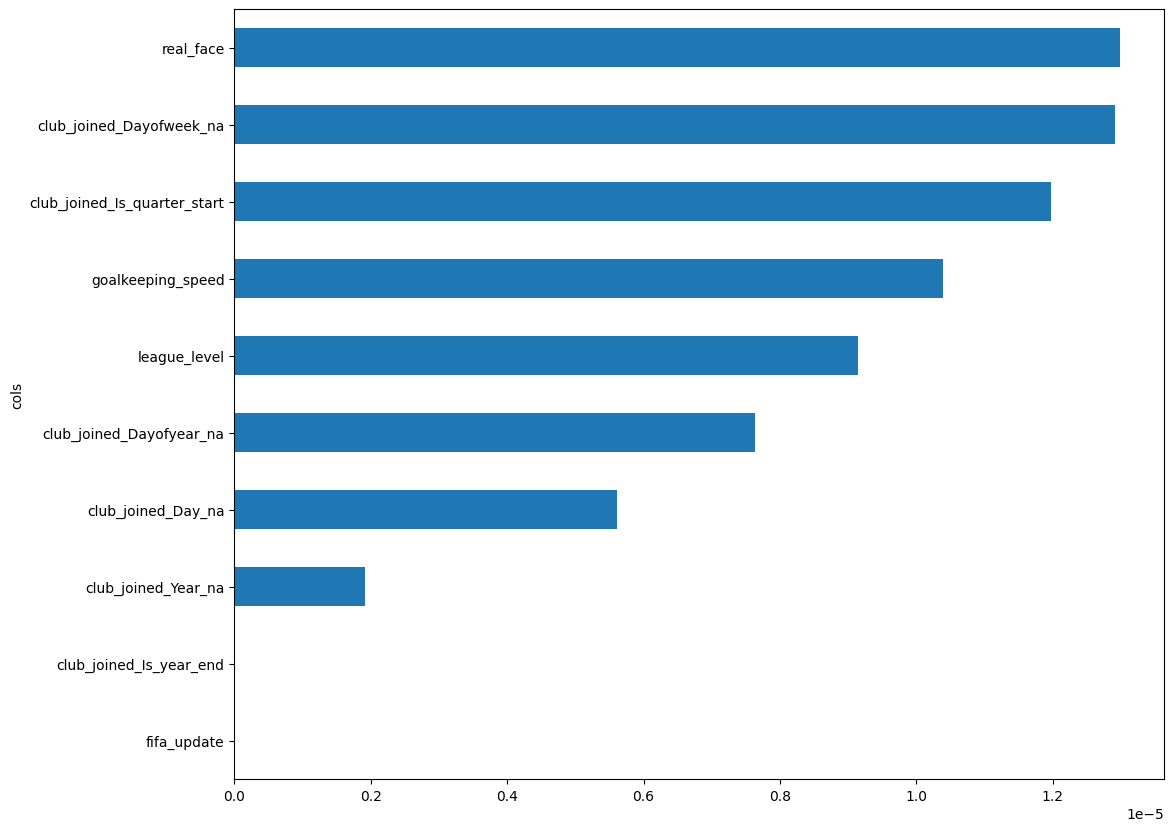

In [204]:
feat_importance = rf_feat_importance(model, X_small)
feat_importance = feat_importance[-10:]
barh = feat_importance.plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh